## Homework_2023_05_15 时间序列 & 神经网络基础   
教师：胡俊峰

助教：谷东润 陈福康

本次作业总分为13分，达到10分即为满分，另外3分是附加分

注意：为提高大家的知识理解与应用能力，时间序列部分需要你自行发挥的内容较多，这些部分在评分时将不会有硬性的步骤要求，而是根据你完成的质量和分析的质量来综合给分（事实上，整体理解与综合分析能力在时间序列问题中是尤为重要的），不必过于纠结某一具体细节是否在评分标准内，加油！


## 第零部分：请认真阅读代码，理解代码的功能

卡尔曼滤波

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
 
font = {'family': 'SimHei',
        'size': '10.5' 
        }
plt.rc('font', **font)
plt.rc('axes', unicode_minus=False)
 
 
class Kf_Params:
    B = 0  # 外部输入为0
    u = 0  # 外部输入为0
    K = float('nan')  # 卡尔曼增益无需初始化
    z = float('nan')  # 这里无需初始化，每次使用kf_update之前需要输入观察值z
    P = np.diag(np.ones(4))  # 初始P设为0 
 
    # 初始状态：函数外部提供初始化的状态，本例使用观察值进行初始化，vx，vy初始为0
    x = []
    G = []
 
    # 状态转移矩阵A
    # 和线性系统的预测机制有关，这里的线性系统是上一刻的位置加上速度等于当前时刻的位置，而速度本身保持不变
    A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
 
    # 预测噪声协方差矩阵Q：假设预测过程上叠加一个高斯噪声，协方差矩阵为Q
    # 大小取决于对预测过程的信任程度。比如，假设认为运动目标在y轴上的速度可能不匀速，那么可以把这个对角矩阵
    # 的最后一个值调大。有时希望出来的轨迹更平滑，可以把这个调更小
    Q = np.diag(np.ones(4)) * 0.1
 
    # 观测矩阵H：z = H * x
    # 这里的状态是（坐标x， 坐标y， 速度x， 速度y），观察值是（坐标x， 坐标y），所以H = eye(2, 4)
    H = np.eye(2, 4)
 
    # 观测噪声协方差矩阵R：假设观测过程上存在一个高斯噪声，协方差矩阵为R
    # 大小取决于对观察过程的信任程度。比如，假设观测结果中的坐标x值常常很准确，那么矩阵R的第一个值应该比较小
    R = np.diag(np.ones(2)) * 0.1
 
 
def kf_init(px, py, vx, vy):
    # 本例中，状态x为（坐标x， 坐标y， 速度x， 速度y），观测值z为（坐标x， 坐标y）
    kf_params = Kf_Params()
    kf_params.B = 0
    kf_params.u = 0
    kf_params.K = float('nan')
    kf_params.z = float('nan')
    kf_params.P = np.diag(np.ones(4))
    kf_params.x = [px, py, vx, vy]
    kf_params.G = [px, py, vx, vy]
    kf_params.A = np.eye(4) + np.diag(np.ones((1, 2))[0, :], 2)
    kf_params.Q = np.diag(np.ones(4)) * 0.1
    kf_params.H = np.eye(2, 4)
    kf_params.R = np.diag(np.ones(2)) * 0.1
    return kf_params
 
 
def kf_update(kf_params):
    # 以下为卡尔曼滤波的五个方程（步骤）
    a1 = np.dot(kf_params.A, kf_params.x)
    a2 = kf_params.B * kf_params.u
    x_ = np.array(a1) + np.array(a2)
 
    b1 = np.dot(kf_params.A, kf_params.P)
    b2 = np.dot(b1, np.transpose(kf_params.A))
    p_ = np.array(b2) + np.array(kf_params.Q)
 
    c1 = np.dot(p_, np.transpose(kf_params.H))
    c2 = np.dot(kf_params.H, p_)
    c3 = np.dot(c2, np.transpose(kf_params.H))
    c4 = np.array(c3) + np.array(kf_params.R)
    c5 = np.linalg.matrix_power(c4, -1)
    kf_params.K = np.dot(c1, c5)
 
    d1 = np.dot(kf_params.H, x_)
    d2 = np.array(kf_params.z) - np.array(d1)
    d3 = np.dot(kf_params.K, d2)
    kf_params.x = np.array(x_) + np.array(d3)
 
    e1 = np.dot(kf_params.K, kf_params.H)
    e2 = np.dot(e1, p_)
    kf_params.P = np.array(p_) - np.array(e2)
 
    kf_params.G = x_
    return kf_params
 
 
def accuracy(predictions, labels):
    return np.array(predictions) - np.array(labels)
 


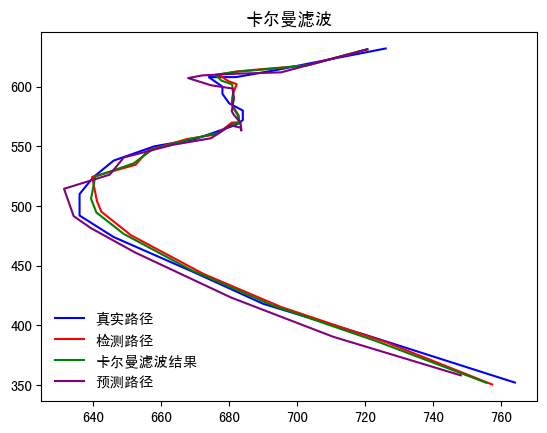

[[-5.4        -0.7       ]
 [-4.58181818 -3.77727273]
 [-1.86696035  0.88942731]
 [ 0.20809969  4.51825545]
 [ 2.00056586  1.98601069]
 [ 1.70377857  1.05589697]
 [ 2.85716089  1.93268741]
 [ 3.16304702  1.44725796]
 [ 0.82221324  0.45770473]
 [-2.79698331  2.02862495]
 [-1.45543694  1.89218001]
 [-1.02643566 -2.58195893]
 [ 1.01894224  0.95448879]
 [ 1.16876094  3.06887511]
 [ 1.10734916 -0.57406179]
 [-1.14701401  0.2172807 ]
 [-0.51547091 -2.48551873]
 [ 5.87618882 -2.3240735 ]
 [ 0.62070854  0.64769776]
 [ 3.37747443 -3.98289077]
 [ 4.95143595  2.53441544]
 [ 2.99332009  2.57928957]
 [-1.17946821  2.29714653]
 [ 2.60174957 -1.21233093]
 [ 3.49455815 -5.54628404]
 [-8.34041064 -0.23971885]]


In [4]:
path = '9.xlsx'
data_A = pd.read_excel(path, header=None)
data_A_x = list(data_A.iloc[::, 0])
data_A_y = list(data_A.iloc[::, 1])
A = np.array(list(zip(data_A_x, data_A_y)))

plt.figure()
plt.plot(data_A_x, data_A_y, 'blue')

# 检测到的路径
path = '10.xlsx'
data_B = pd.read_excel(path, header=None)
data_B_x = list(data_B.iloc[::, 0])
data_B_y = list(data_B.iloc[::, 1])
B = np.array(list(zip(data_B_x, data_B_y)))

plt.plot(data_B_x, data_B_y, 'red')

# 卡尔曼滤波
kf_params_record = np.zeros((len(data_B), 4))
kf_params_p = np.zeros((len(data_B), 4))
t = len(data_B)
kalman_filter_params = kf_init(data_B_x[0], data_B_y[0], 0, 0)
for i in range(t):
    if i == 0:
        kalman_filter_params = kf_init(data_B_x[i], data_B_y[i], 0, 0)  # 初始化
    else:            
        kalman_filter_params.z = np.transpose([data_B_x[i], data_B_y[i]])  # 设置当前时刻的观测位置
        kalman_filter_params = kf_update(kalman_filter_params)  # 卡尔曼滤波
    kf_params_record[i, ::] = np.transpose(kalman_filter_params.x)
    kf_params_p[i, ::] = np.transpose(kalman_filter_params.G)

kf_trace = kf_params_record[::, :2]
kf_trace_1 = kf_params_p[::, :2]

plt.plot(kf_trace[::, 0], kf_trace[::, 1], 'green')
plt.plot(kf_trace_1[1:26, 0], kf_trace_1[1:26, 1], 'purple')
legend = ['真实路径', '检测路径', '卡尔曼滤波结果', '预测路径']
plt.legend(legend, loc="best", frameon=False)
plt.title('卡尔曼滤波')
plt.show()

p = accuracy(kf_trace, A)
print(p)

## 第一部分：时间序列（8分）

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import seaborn as sns
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

df = pd.read_csv('Stock_Price.csv')
df.head()


,Date,TWTR,KO,GM
0,2013-11-07,44.900002,30.350573,27.762348
1,2013-11-08,41.650002,30.518206,28.334280
2,2013-11-11,42.900002,30.381044,28.349743
3,2013-11-12,41.900002,30.388666,28.334280
4,2013-11-13,42.599998,30.571535,29.710032


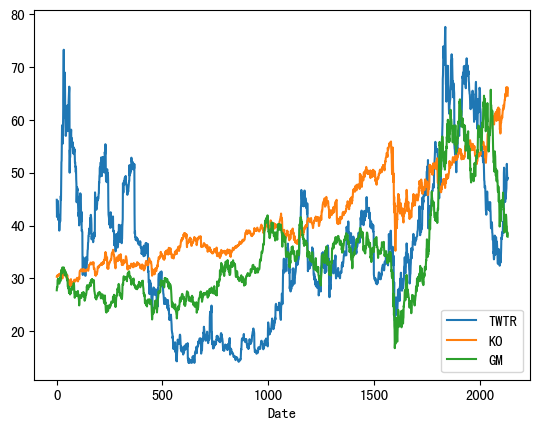

In [6]:
df[['TWTR', 'KO', 'GM']].plot()
plt.xlabel('Date')
plt.show()

1.1 请你结合课上老师讲授的知识、上次作业以及其它查阅得到的知识，对这三支股票的股价时间序列的基本性质与特征（平稳性、周期性等）进行分析，并可以尝试分析三支股票是否有（或在某些局部的时间段有）关联（2分）

股票代码: TWTR
平稳性检验结果:
p-value: 0.24160297489559274
adf: -2.107265967482351
nobs: 2118
序列不是平稳的 (p-value >= 0.05)
相关性图:


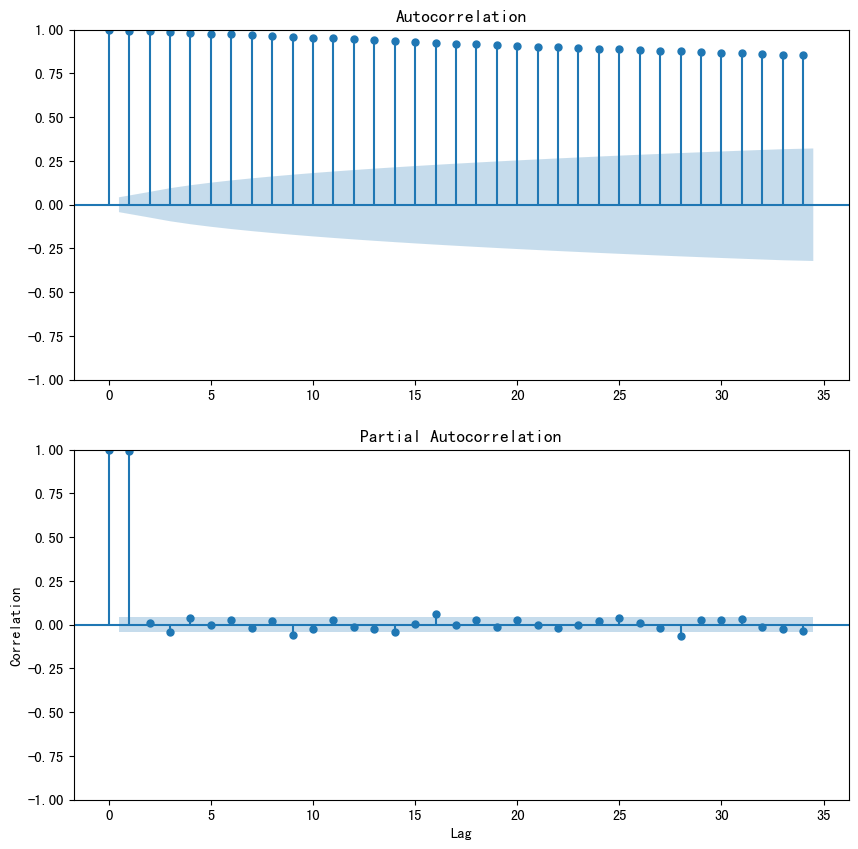

-----------------------------
股票代码: KO
平稳性检验结果:
p-value: 0.9617365050440163
adf: 0.04024578111864328
nobs: 2121
序列不是平稳的 (p-value >= 0.05)
相关性图:


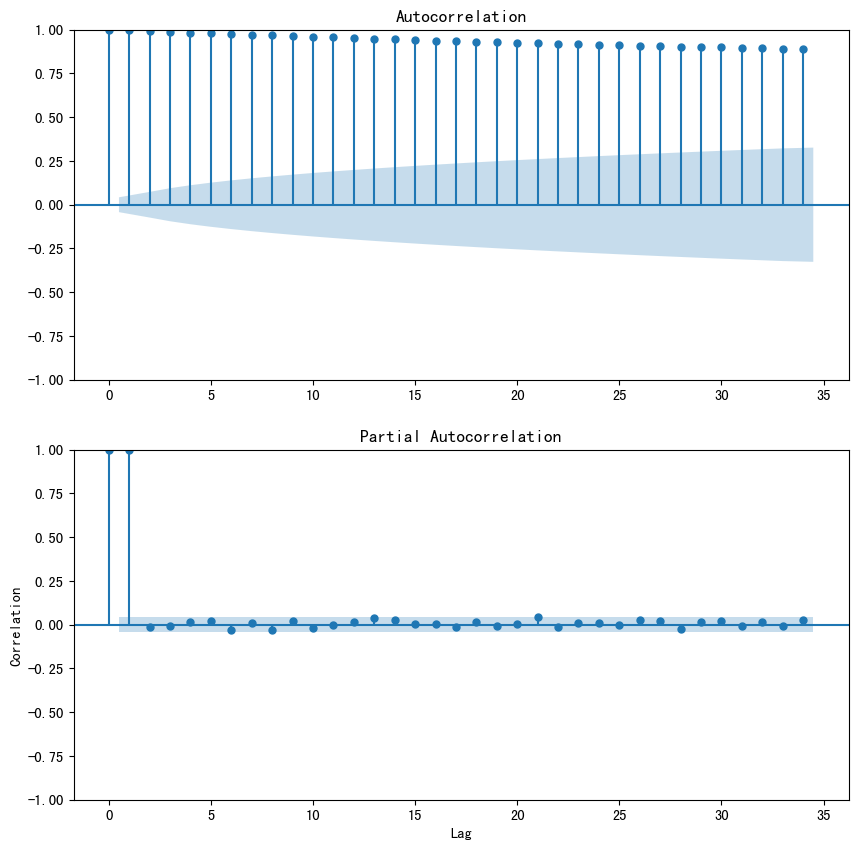

-----------------------------
股票代码: GM
平稳性检验结果:
p-value: 0.40715227267731136
adf: -1.746845115563993
nobs: 2114
序列不是平稳的 (p-value >= 0.05)
相关性图:


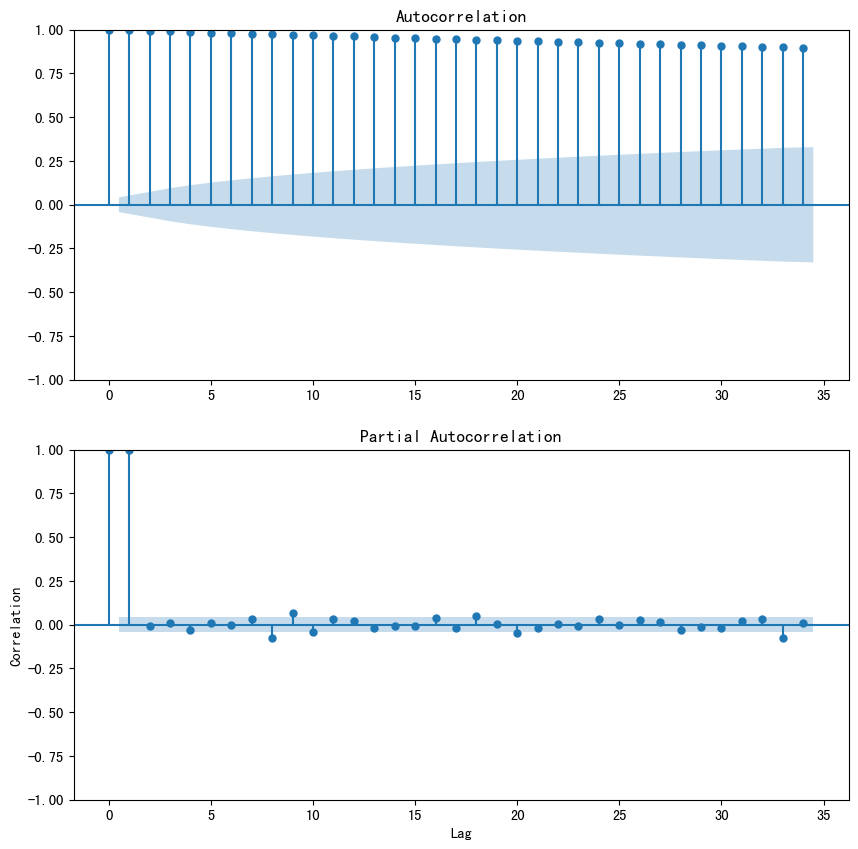

-----------------------------
股票之间的关联性:
          TWTR        KO        GM
TWTR  1.000000  0.361358  0.560139
KO    0.361358  1.000000  0.742656
GM    0.560139  0.742656  1.000000


In [7]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

# 读取数据
df = pd.read_csv('./Stock_Price.csv')

# 提取股票数据
twtr_data = df['TWTR']
ko_data = df['KO']
gm_data = df['GM']

# 检验平稳性
def check_stationarity(data):

    adf,p_value,usedlag,nobs,critical_values,icbest = adfuller(data)
    print(f'p-value: {p_value}')
    print(f'adf: {adf}')
    print(f'nobs: {nobs}')
    if p_value < 0.05:
        print("序列是平稳的 (p-value < 0.05)")
    else:
        print("序列不是平稳的 (p-value >= 0.05)")

# 分析每支股票的平稳性和自相关性
for stock, data in [('TWTR', twtr_data), ('KO', ko_data), ('GM', gm_data)]:
    print(f"股票代码: {stock}")
    print("平稳性检验结果:")
    check_stationarity(data)
    print("相关性图:")
    fig, axes = plt.subplots(2, 1, figsize=(10, 10))
    
    plot_acf(data, ax=axes[0])
    plot_pacf(data, ax=axes[1],method="ywm")
    
    plt.xlabel('Lag')
    plt.ylabel('Correlation')
    plt.show()
    print("-----------------------------")

# 分析股票之间的关联性
print("股票之间的关联性:")
correlation_matrix = df[['TWTR', 'KO', 'GM']].corr()
print(correlation_matrix)


1.2 请你自行发挥，根据你对于时间序列的理解并结合上网查阅资料，给出一些股票时间序列能反映趋势或可以用来预测涨跌的指标（你也可以尝试进行自定义指标），给出指标的定义以及计算指标的代码，并借助该股票数据分析效果（4分）

（没有思路的同学可以尝试计算分析股票的KDJ指标和双均线指标，分析合理即可）

KDJ 指标

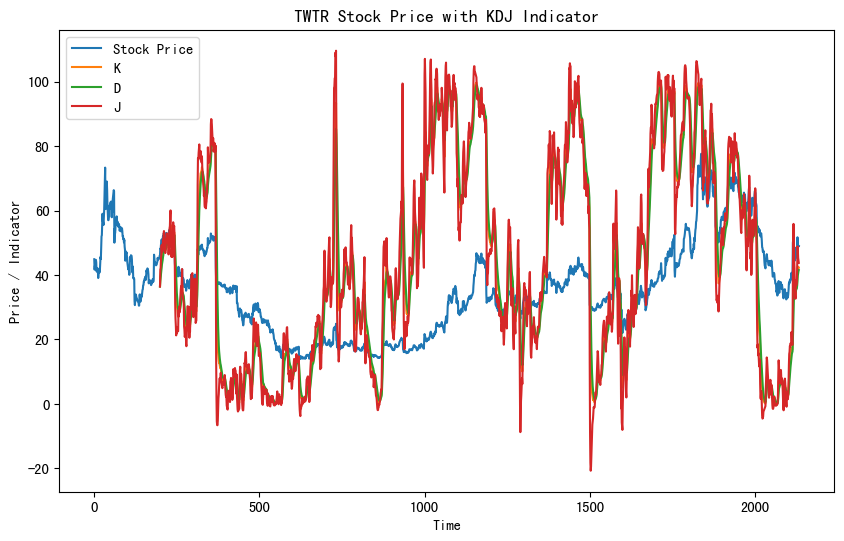

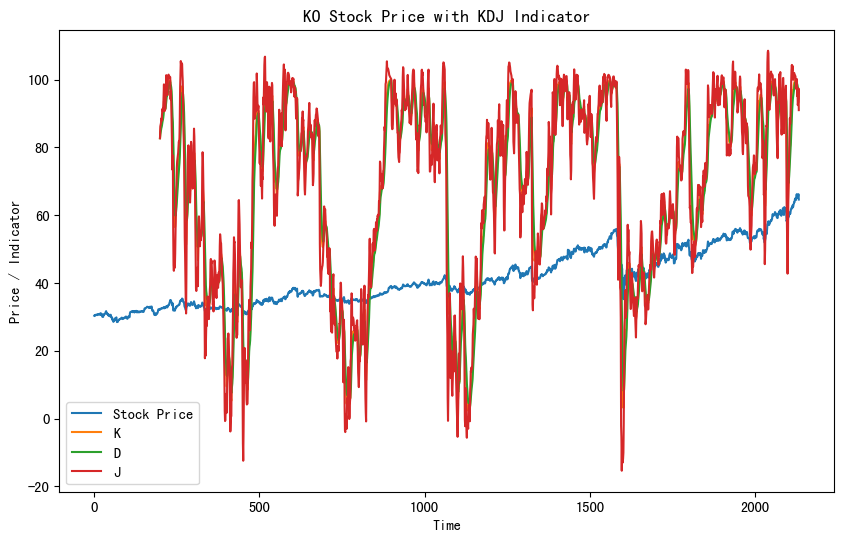

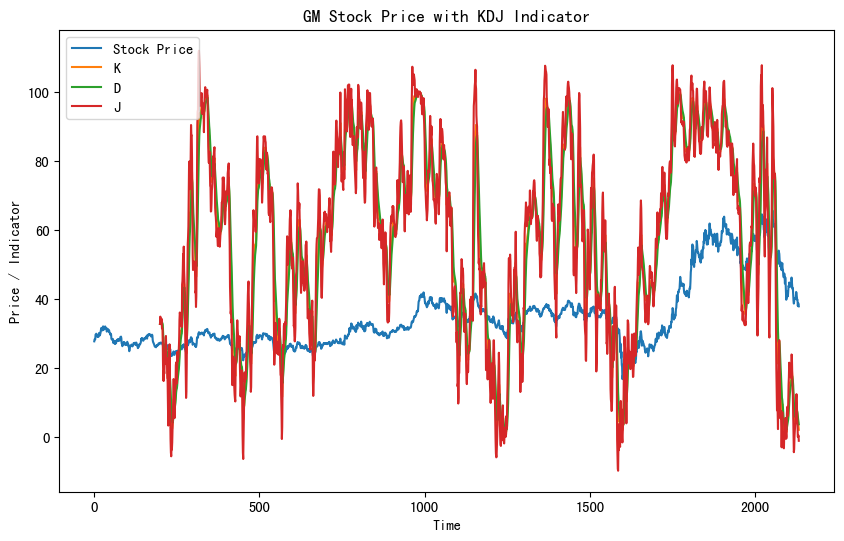

In [8]:
def KDF_indicator(stock_name,stock_data):
    # 计算KDJ指标
    n = 200  # KDJ指标参数
    low_min = stock_data.rolling(window=n).min()
    high_max = stock_data.rolling(window=n).max()
    rsv = (stock_data - low_min) / (high_max - low_min) * 100
    k = rsv.ewm(com=2).mean()
    d = k.ewm(com=2).mean()
    j = 3 * k - 2 * d

    # 绘制KDJ指标图表
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data, label='Stock Price')
    plt.plot(k, label='K')
    plt.plot(d, label='D')
    plt.plot(j, label='J')
    plt.title(f'{stock_name} Stock Price with KDJ Indicator')
    plt.xlabel('Time')
    plt.ylabel('Price / Indicator')
    plt.legend()
    plt.show()


for stock, data in [('TWTR', twtr_data), ('KO', ko_data), ('GM', gm_data)]:
    KDF_indicator(stock,data)


双均线指标

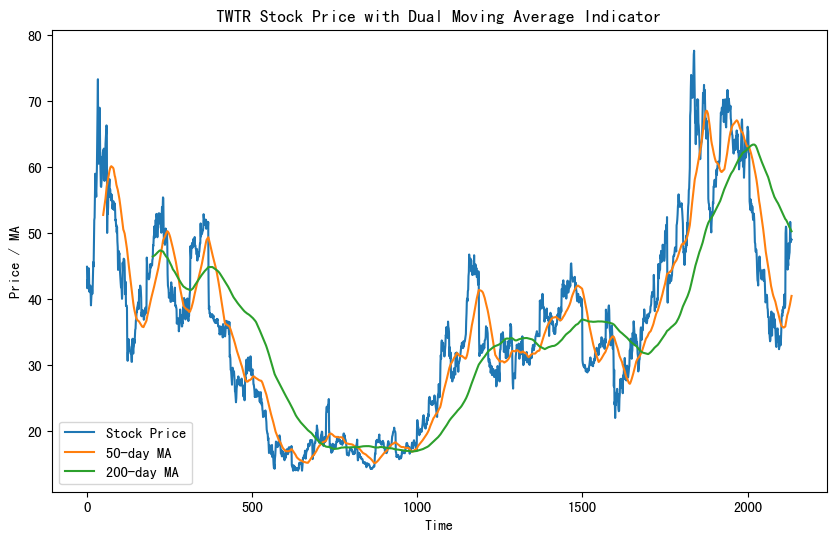

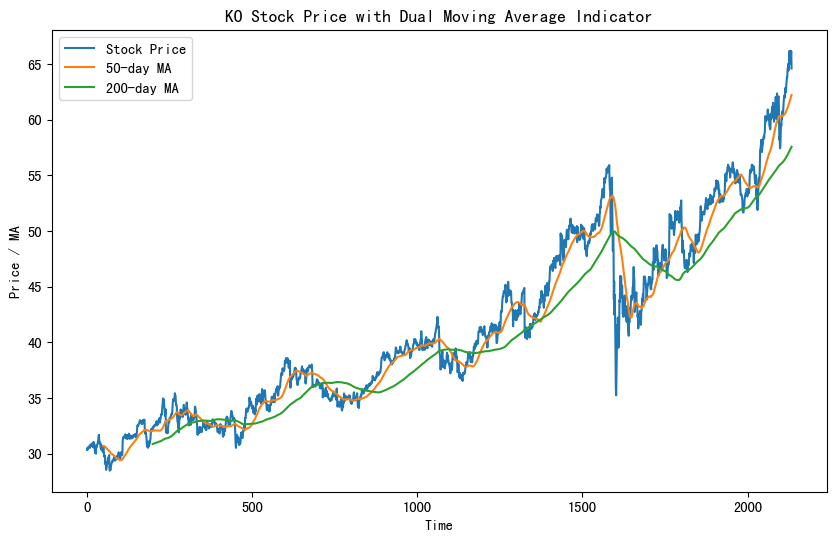

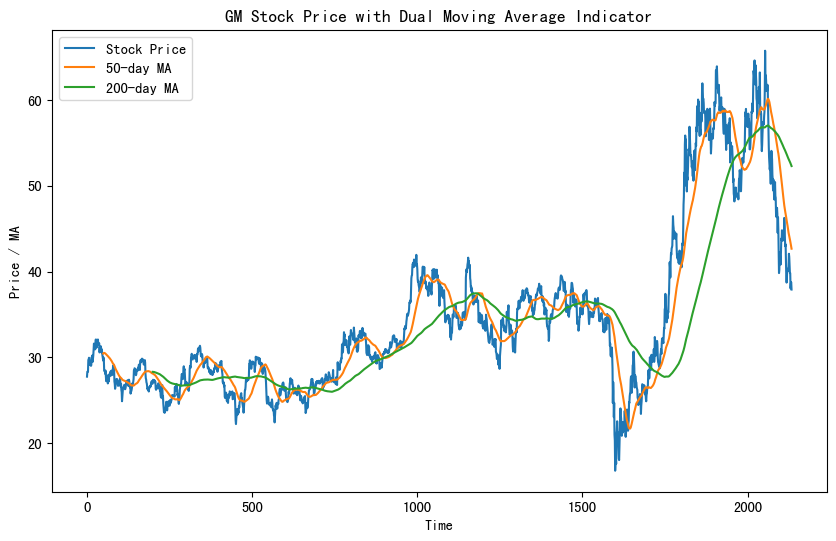

In [9]:
def Dual_Moving_Average_Indicator(stock_name,stock_data):
    # 计算双均线指标
    short_window = 50  # 短期均线窗口大小
    long_window = 200  # 长期均线窗口大小
    short_rolling = stock_data.rolling(window=short_window).mean()
    long_rolling = stock_data.rolling(window=long_window).mean()

    # 绘制双均线指标图表
    plt.figure(figsize=(10, 6))
    plt.plot(stock_data, label='Stock Price')
    plt.plot(short_rolling, label=f'{short_window}-day MA')
    plt.plot(long_rolling, label=f'{long_window}-day MA')
    plt.title(f'{stock_name} Stock Price with Dual Moving Average Indicator')
    plt.xlabel('Time')
    plt.ylabel('Price / MA')
    plt.legend()
    plt.show()
for stock, data in [('TWTR', twtr_data), ('KO', ko_data), ('GM', gm_data)]:
    Dual_Moving_Average_Indicator(stock,data)

1.3 噪声处理（2分）

example.wav中录制了一段鸟鸣声，但背景中存在很大的噪声，希望能编写一段程序去除噪声。这里采用的是librosa库，有关内容可参考其官方文档https://librosa.org/doc/latest/tutorial.html
<br>（1）绘制音频文件example.wav的图像。
<br>（2）去除音频文件中的噪声。（可使用scipy.signal.lfilter）https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
<br>（3）绘制去除噪声后的音频文件图像。

In [10]:
import librosa
import librosa.display
from scipy import signal
from IPython.display import Audio,display

sr = 16000
e_file='example.wav'
y,sr = librosa.load(e_file, mono=True, sr=sr, offset=0, duration=10)

display(Audio(y,rate=sr))

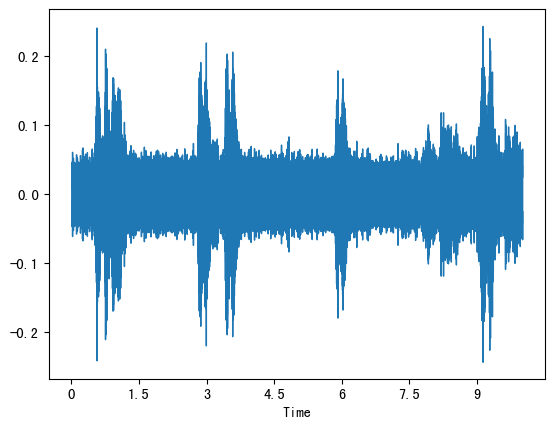

In [11]:
librosa.display.waveshow(y,sr=sr)

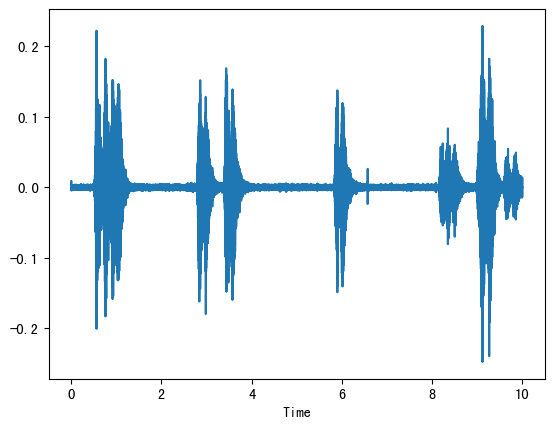

In [12]:
#todo
b, a = signal.butter(5, 0.3, 'highpass')
y_filt = signal.filtfilt(b, a, y)
# 去噪后
x_filt = np.arange(len(y_filt)) * (10/len(y_filt))
plt.plot(x_filt, y_filt)
plt.xlabel('Time')
plt.show()
display(Audio(y_filt,rate=sr))


## 第二部分：神经网络基础(5分)

2.1补全下列常用的激活函数及其导数,熟记并画出它们的图像（2分），你也可以查阅资料后补充一些其它常用的激活函数（不计分）

In [13]:
def sigmoid(x):
    #todo
    return 1.0/(1.0 + np.exp(-x))

def d_sigmoid(x):
    #todo
    return sigmoid(x)*(1-sigmoid(x))

def ReLU(x):
    #todo
    return np.maximum(0,x)

def d_ReLU(x):
    #todo
    return np.where(x>0,1,0)

def Tanh(x):
    #todo
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

def d_Tanh(x):
    #todo
    return 1-Tanh(x)**2


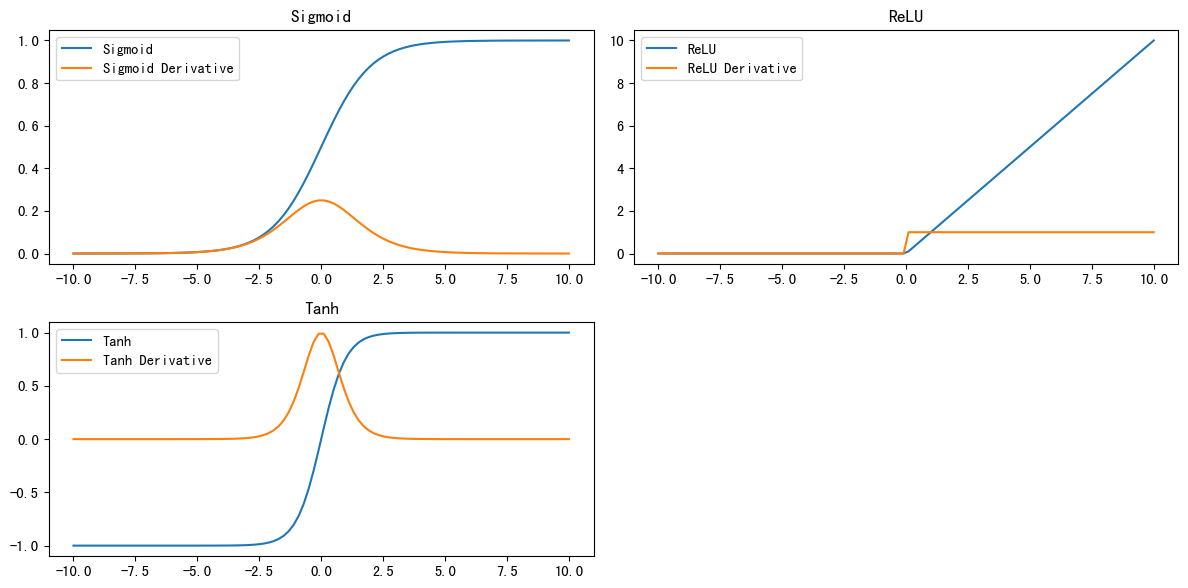

In [14]:
#画出上述常用激活函数与对应导数在区间[-10,10]的图像
#todo

x = np.linspace(-10, 10, 100)
y_sigmoid = sigmoid(x)
dy_sigmoid = d_sigmoid(x)

y_ReLU = ReLU(x)
dy_ReLU = d_ReLU(x)

y_tanh = Tanh(x)
dy_tanh = d_Tanh(x)

plt.figure(figsize=(12, 6))

plt.subplot(2, 2, 1)
plt.plot(x, y_sigmoid, label='Sigmoid')
plt.plot(x, dy_sigmoid, label="Sigmoid Derivative")
plt.title('Sigmoid')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(x, y_ReLU, label='ReLU')
plt.plot(x, dy_ReLU, label="ReLU Derivative")
plt.title('ReLU')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(x, y_tanh, label='Tanh')
plt.plot(x, dy_tanh, label="Tanh Derivative")
plt.title('Tanh')
plt.legend()

plt.tight_layout()
plt.show()


2.2使用反向传播算法，用三次函数拟合sin(x)函数在$[-\pi,\pi]$区间的取值（3分）

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import math
#在区间等距离散采样
x = np.linspace(-math.pi,math.pi,200)
y = np.sin(x)

In [16]:
#初始化a+b*x+c*x^2+d*x^3中的参数a,b,c,d
a = np.random.randn()
b = np.random.randn()
c = np.random.randn()
d = np.random.randn()

learning_rate = 1e-3    #可尝试对比不同的学习率，不计分

In [17]:
for t in range(6000):
    y_pred = a + b*x + c*x**2 + d*x**3
    
    #计算loss（0.5分）
    #todo
    loss=np.mean((y_pred-y)**2)
 
    print(t, loss)
    
    #反向传播（1分）
    #todo
    grad_y_pred=2.0*(y_pred-y)
    grad_a=np.mean(grad_y_pred)
    grad_b=np.mean(grad_y_pred*x)
    grad_c=np.mean(grad_y_pred*x**2)
    grad_d=np.mean(grad_y_pred*x**3)
 
    # 更新参数（1分）
    #todo
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

 
print(f'Result: y = {a} + {b} x + {c} x^2 + {d} x^3')


0 82.00101386782622
1 48.93363300329484
2 31.612014050689613
3 22.30570316656492
4 17.098880220885384
5 14.006449544276098
6 12.020650043119735
7 10.62856320963323
8 9.567924149600096
9 8.703529189613194
10 7.9646737505997836
11 7.313476409510198
12 6.728834412501617
13 6.198290769207922
14 5.713906138645591
15 5.270158361631855
16 4.862869011782294
17 4.4886505170116076
18 4.144617492561227
19 3.828232491341153
20 3.537220431334213
21 3.2695183793372053
22 3.0232437806431927
23 2.7966725326946453
24 2.588222508827008
25 2.3964402710235317
26 2.2199897929271617
27 2.057642564838482
28 1.9082687335481074
29 1.7708290744541548
30 1.6443676687447237
31 1.5280051985261645
32 1.4209327948926067
33 1.322406386798911
34 1.2317415066518003
35 1.14830851402674
36 1.0715282030020765
37 1.0008677618684068
38 0.9358370567278268
39 0.8759852129080165
40 0.8208974702697966
41 0.7701922904358289
42 0.7235186957447547
43 0.6805538213611638
44 0.6410006634634652
45 0.6045860078018063
46 0.5710585241774

画出得到的三次函数与sinx在$[-\pi,\pi]$区间内的图像(0.5分)

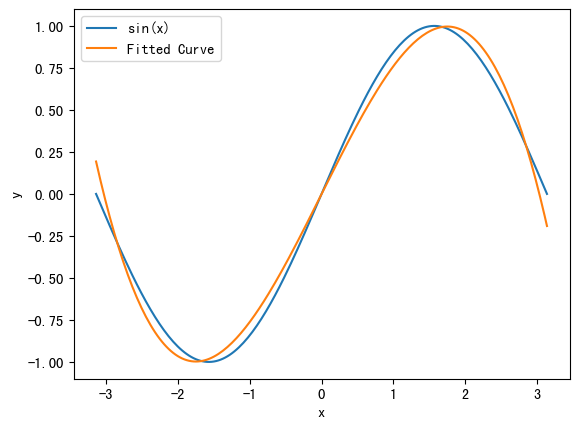

In [18]:
#todo
y_fit = a + b*x + c*x**2 + d*x**3

plt.plot(x, y, label="sin(x)")
plt.plot(x, y_fit, label="Fitted Curve")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()